In [1]:
using LinearAlgebra, PreallocationTools, ForwardDiff, DiffResults
using MPI
include("XBraid.jl")
using .XBraid

MPI.Init()
comm = MPI.COMM_WORLD

MPI.Comm(Ptr{Nothing} @0x00007f851adefc20)

In [2]:
# system parameters (globally scoped)
const nₓ = 64
const Δx = 2π / nₓ
const Δt = 0.1
x = Array(range(0.0, 2π - Δx, nₓ))

# preallocations (performance critical, passed as arguments)
x_new = zeros(nₓ)
y_new = zeros(nₓ)

struct burger_app
    x
    # preallocated caches that support ForwardDiff:
    x_d::DiffCache
    y_d::DiffCache
    solution # stores the total solution vecdtor over space-time
    lyap_vecs # stores the lyapunov vectors
    lyap_exps # stores the lyapunov exponents
    times
end
burger_app(x, x_d, y_d) = burger_app(x, x_d, y_d, [], [], [], [])


burger_app

In [3]:
function interp_periodic(coord, f)
    bound = nₓ
    scaled = coord / Δx
    i = trunc(scaled)
    r = scaled - i
    i = mod1(Int(i + 1), bound)
    (1 - r) * f[i] + r * f[mod1(i + 1, bound)]
end

function semi_lagrangian!(burger::burger_app, y, Δt)
    x_back = get_tmp(burger.x_d, y)
    y_intp = get_tmp(burger.y_d, y)

    x_back .= x .- Δt * y
    y_intp .= interp_periodic.(x_back, Ref(y))
    y .= y_intp
    return y
end

function my_init(burger, t)
    u = similar(x)
    u .= sin.(x) .+ 1e-2*randn(length(x))
    # u .= sin.(x)
    return u
end

function my_basis_init(burger, t, k)
    ψ = similar(burger.x)
    if k % 2 == 0
        @. ψ = cos(k/2*x)
    else
        @. ψ = sin((k+1)/2*x)
    end
    return ψ
end

function my_step!(burger, status, u, ustop, tstart, tstop)
    Δt = tstop - tstart
    u = semi_lagrangian!(burger, u, Δt)
    return
end

function my_step!(burger, status, u, ustop, tstart, tstop, Ψ)
    Δt = tstop - tstart
    rank = length(Ψ)
    Ψ_new = reduce(hcat, Ψ)
    # perturb(r) = semi_lagrangian!(burger, u + Ψ_new * r, Δt)
    perturb(r) = semi_lagrangian!(burger, u + r' * Ψ, Δt)

    result = DiffResults.DiffResult(u, Ψ_new)
    result = ForwardDiff.jacobian!(result, perturb, zeros(rank))
    for i in 1:length(Ψ)
        Ψ[i] .= Ψ_new[:, i]
    end
end

function my_sum!(burger, a, x, b, y)
    @. y = a*x + b*y
end

function my_access(burger, status, u)
    push!(burger.solution, deepcopy(u))
    t = XBraid.status_GetT(status)
    ti = XBraid.status_GetTIndex(status)
    push!(burger.times, t)
    Ψ = XBraid.status_GetBasisVectors(status)
    push!(burger.lyap_vecs, deepcopy(Ψ))
    λ = XBraid.status_GetLocalLyapExponents(status)
    push!(burger.lyap_exps, deepcopy(λ))
end

my_norm(burger, u) = LinearAlgebra.norm2(u)
my_innerprod(burger, u, v) = u' * v

my_innerprod (generic function with 1 method)

In [4]:
burger = burger_app(x, DiffCache(x_new), DiffCache(y_new));

# test user routines:
test_app = XBraid.BraidApp(
    burger, comm, comm, 
    my_step!, my_init,
    my_sum!, my_norm, my_access,
    my_basis_init, my_innerprod);
XBraid.testInitAccess(test_app, 0.)
XBraid.testSpatialNorm(test_app, 0.)
XBraid.testDelta(test_app, 0., 0.1, 3)


Starting braid_TestInitAccess

   braid_TestInitAccess:   Starting Test 1
   braid_TestInitAccess:   u = init(t=0.00e+00)
   braid_TestInitAccess:   access(u) 
   braid_TestInitAccess:   check output: wrote u for initial condition at t=0.00e+00. 

   braid_TestInitAccess:   free(u) 
Finished braid_TestInitAccess
Serialized size of user vector: 561
Check output for objects not properly freed:
IdDict{Any, Any}()

Starting braid_TestSpatialNorm

   braid_TestSpatialNorm:   Starting Test 1
   braid_TestSpatialNorm:   u = init(t=0.00e+00)
   braid_TestSpatialNorm:   spatialnorm(u) 
   braid_TestSpatialNorm:   v = clone(u)
   braid_TestSpatialNorm:   v = u - v 
   braid_TestSpatialNorm:   spatialnorm(v) 
   braid_TestSpatialNorm:   Test 1 Passed
   braid_TestSpatialNorm:   actual output:    spatialnorm(v) = 0.00e+00  
   braid_TestSpatialNorm:   expected output:  spatialnorm(v) = 0.0 

   braid_TestSpatialNorm:   Starting Test 2
   braid_TestSpatialNorm:   w = clone(u)
   braid_TestSpatialN

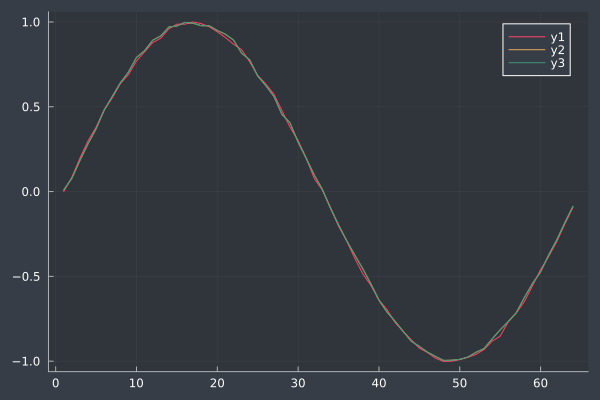

In [5]:
using Plots
theme(:dark)
plot(burger.solution)

In [6]:
burger = burger_app(x, DiffCache(x_new), DiffCache(y_new));
tstart = 0.0
tstop = 4.0
ntime = 128
delta_rank = 1

core = XBraid.Init(
    comm, comm, tstart, tstop, ntime,
    my_step!, my_init, my_sum!, my_norm, my_access; app=burger
);

In [8]:
XBraid.SetDeltaCorrection(core, delta_rank, my_basis_init, my_innerprod)
XBraid.SetLyapunovEstimation(core, false, true, true)
XBraid.SetMaxLevels(core, 3)
XBraid.SetCFactor(core, -1, 4)
XBraid.SetAccessLevel(core, 1)
XBraid.SetNRelax(core, -1, 0)
XBraid.Drive(core)

Error in user Step: InexactError(:

: 

: 

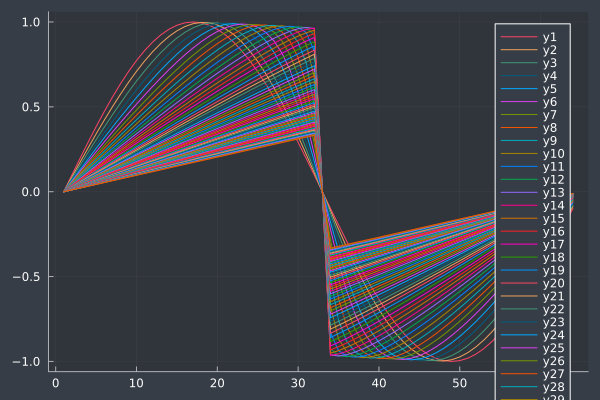

In [7]:
p = sortperm(burger.times)
plot(burger.solution[p][1:2:end])

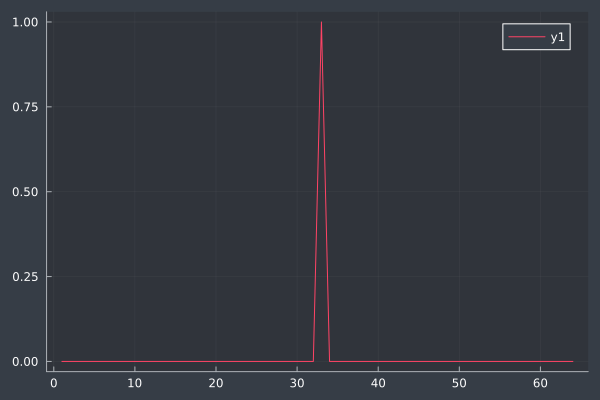

In [8]:
# plot([v[1] for v in burger.lyap_vecs[p]])
plot(burger.lyap_vecs[p][end][1])

In [9]:
sum(burger.lyap_exps[p]) ./ tstop

1-element Vector{Float64}:
 4.345330409372988

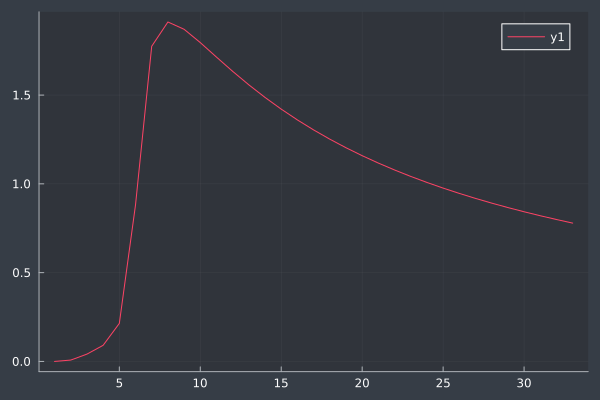

In [10]:
plot(reduce(hcat, burger.lyap_exps[p])'[1:4:end, :])